In case torchinfo is not installed, install it.

In [ ]:
!pip install torchinfo

In [ ]:
import os
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

Mounted at /content/drive


Path of the source file to access python modules.

In [ ]:
project_path_rel = "MyDrive/desktop/new_academia/ML_DS_Statistics/YOLO/"
project_path = os.path.join(drive_path, project_path_rel)

In [ ]:
! cp -r {project_path}* ./

Import necessary python packages

In [ ]:
import numpy as np
import torch
import gc
import json
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Device on which training to be done
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PRECISION to be used for weights of model
PRECISION = torch.float

In [ ]:
from src import (dataParser as dp, 
                 dataLoader as dl,
                 model,
                 utils)

Load Raw data from the desired dataset

In [ ]:
# VOC
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xvf ./VOCtrainval_11-May-2012.tar

# # COCO
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/annotations_trainval2017.zip" -d .
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/coco/train2017.zip" -d .

# # BDD100K LABELS
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_det_20_labels_trainval.zip" -d .

# # BDD100K IMAGES
# !unzip "/content/drive/MyDrive/ML_DS_Statistics/Dataset/bdd/bdd100k_images_100k.zip" -d .

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

Parse the raw data into desired format

We will parse all the individual images into following formats.

Each image:
```
image = {
          'file': {NAME_OF_FILE},
          'height': {HEIGHT_OF_IMAGE},
          'width': {WIDTH_OF_IMAGE},
          'objects: [{'bbox':[x_min,y_min,b_width,b_height], 'name': {LABEL_OF_OBJECT} }, ...]
        }
```

Entire dataset will be python list of these dictionaries<

In [ ]:
# Parse annotations 
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

# Name of the labels in VOC
LABELS_VOC = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
              'bus',        'car',      'cat',  'chair',     'cow',
              'diningtable','dog',    'horse',  'motorbike', 'person',
              'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

for idx, label in enumerate(LABELS_VOC):
  LABELS_VOC[idx] = dp.cat_name_COCO_to_VOC(label)

train_image_voc = dp.parse_annotation_VOC(train_annot_folder,train_image_folder, labels=LABELS_VOC)

train_image = train_image_voc
LABELS = LABELS_VOC

_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])

In [ ]:
# dataDir='.'
# dataType='train2017'
# annFile=f"{dataDir}/annotations/instances_{dataType}.json"

# my_json = json.load(open(annFile, 'r'))
# id_to_image = dp.COCO_json_img(my_json)
# id_to_cat = dp.COCO_json_cat(my_json)
# id_to_image = dp.attach_objs(id_to_image, id_to_cat, my_json)

# LABELS_COCO = list(id_to_cat.values())
# train_image_coco = list(id_to_image.values())


# train_image = train_image_coco
# LABELS = LABELS_COCO


# _ANCHORS01 = np.array([0.22905231, 0.327348,
#                       0.0601304 , 0.07305195,
#                       0.02738149, 0.05411568,
#                       0.01381426, 0.02333195,
#                       0.15897478, 0.17922826,
#                       0.36362706, 0.53264426,
#                       0.08428863, 0.14411576,
#                       0.1, 0.03])
# del my_json #, id_to_image
# gc.collect()

# for coco_img in train_image:
#   coco_img["file"] = os.path.join("train2017", os.path.basename(coco_img["file"]))

In [ ]:
# dataDir='./bdd100k'
# dataType='train'
# img_folder = './bdd100k/images/100k/train/'
# annFile=f"{dataDir}/labels/det_20/det_{dataType}.json"
# # Name of the labels in VOC
# LABELS_BDD = ['pedestrian', 'rider', 'car', 'truck', 'bus',
#               'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']

# my_json = json.load(open(annFile, 'r'))

# train_image_bdd = dp.bdd_to_format(my_json, img_folder, is_attributes=False)


In [ ]:
shuffle = False
loader_args = dict(shuffle=shuffle, batch_size=16, pin_memory=False, drop_last=True )

In [ ]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [ ]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'image_h'         : IMAGE_H, 
    'image_w'         : IMAGE_W,
    'grid_h'          : GRID_H,  
    'grid_w'          : GRID_W,
    'box'             : BOX,
    'classes'          : LABELS,
    'anchors'         : ANCHORS,
    'batch_size'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_dataset = dl.YOLOData(train_image, generator_config,
                                      norm=True, shuffle=shuffle)

In [ ]:
train_batch_generator = torch.utils.data.DataLoader(train_dataset, **loader_args)

In [ ]:
my_iter = iter(train_batch_generator)

In [ ]:
[x_batch,b_batch],y_batch = next(my_iter)
print(f"x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {x_batch.shape}")
print(f"y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {y_batch.shape}")
print(f"b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {b_batch.shape}")

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = torch.Size([16, 3, 416, 416])
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = torch.Size([16, 6, 4, 13, 13])
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = torch.Size([16, 4, 50, 1, 1, 1])


In [ ]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["grid_h"]):
        for igrid_w in range(generator_config["grid_w"]):
            for ianchor in range(generator_config["box"]):
                vec = y_batch[irow,:,ianchor,igrid_h,igrid_w]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    classes = vec[5:6].type(torch.int32).numpy()
                    class_nm = np.array(LABELS)[classes]
                    print(class_nm, igrid_h, igrid_w, ianchor)
                    assert len(class_nm) == 1
                    print(f"igrid_h={igrid_h:02.0f},igrid_w={igrid_w:02.0f},iAnchor={ianchor:02.0f}, {class_nm[0]}")
check_object_in_grid_anchor_pair(iframe)

['airplane'] 4 4 0
igrid_h=04,igrid_w=04,iAnchor=00, airplane
['airplane'] 6 6 3
igrid_h=06,igrid_w=06,iAnchor=03, airplane
['person'] 9 0 0
igrid_h=09,igrid_w=00,iAnchor=00, person
['person'] 9 5 0
igrid_h=09,igrid_w=05,iAnchor=00, person


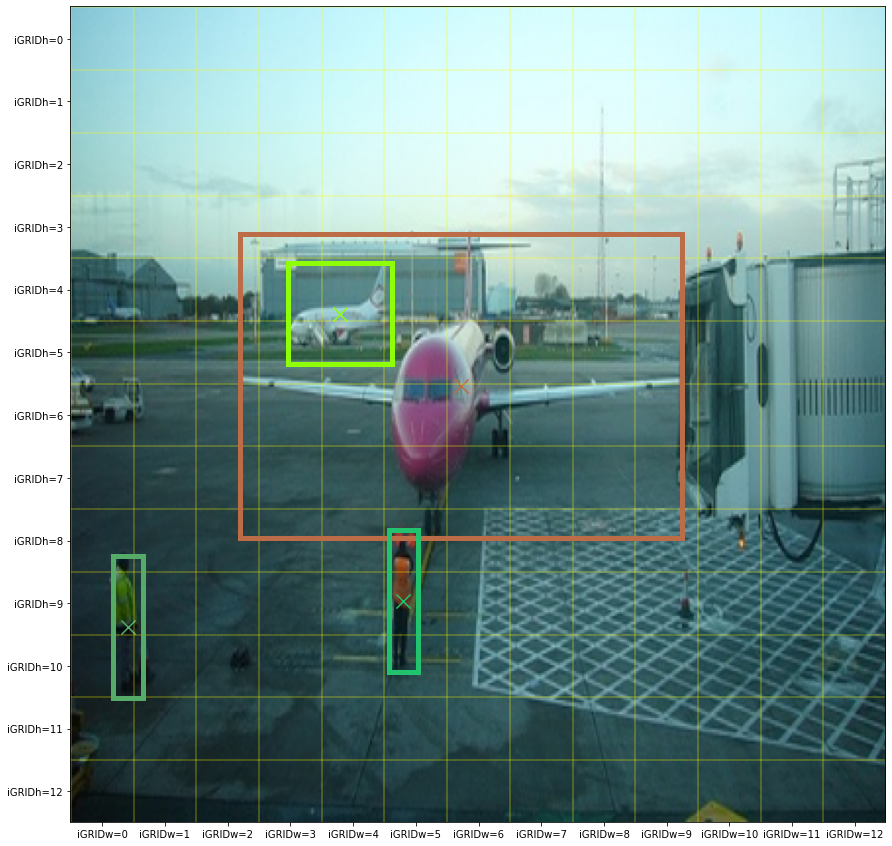

In [ ]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow].numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["w","h"]:
        GRID_       = generator_config["grid_"  + wh] ## 13
        IMAGE_      = generator_config["image_" + wh] ## 416
        if wh == "w":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                [f"iGRID{wh}={i}" for i in range(GRID_)])

def plot_grid(irow):
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["grid_h"]):
        for igrid_w in range(generator_config["grid_w"]):
            for ianchor in range(generator_config["box"]):
                vec = y_batch[irow,:,ianchor,igrid_h,igrid_w]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x_o, y_o, w, h = vec[:4]
                    multx = generator_config["image_w"]/generator_config["grid_w"]
                    multy = generator_config["image_h"]/generator_config["grid_h"]
                    c = color_palette[iobj]
                    iobj += 1
                    x = x_o #+ igrid_w
                    y = y_o #+ igrid_h
                    xmin = x - 0.5*w 
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h  
                    # center
                    plt.scatter(x*multx,y*multy,
                             marker='x',color=c,s=200)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=5)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=5)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=5)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=5)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

In [ ]:
for irow in range(5, 10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Neural Network Model

In [ ]:
myVGG = model.VGGYOLO(CLASS=len(LABELS), BOX=len(_ANCHORS01)//2)

In [ ]:
from torchinfo import summary
summary(myVGG, input_size=((16, 3, 416, 416)))

Layer (type:depth-idx)                   Output Shape              Param #
VGGYOLO                                  --                        --
├─Sequential: 1-1                        [16, 512, 26, 26]         --
│    └─Sequential: 2-1                   [16, 32, 208, 208]        --
│    │    └─Conv2d: 3-1                  [16, 32, 416, 416]        864
│    │    └─BatchNorm2d: 3-2             [16, 32, 416, 416]        64
│    │    └─LeakyReLU: 3-3               [16, 32, 416, 416]        --
│    │    └─MaxPool2d: 3-4               [16, 32, 208, 208]        --
│    └─Sequential: 2-2                   [16, 64, 104, 104]        --
│    │    └─Conv2d: 3-5                  [16, 64, 208, 208]        18,432
│    │    └─BatchNorm2d: 3-6             [16, 64, 208, 208]        128
│    │    └─LeakyReLU: 3-7               [16, 64, 208, 208]        --
│    │    └─MaxPool2d: 3-8               [16, 64, 104, 104]        --
│    └─Sequential: 2-3                   [16, 128, 104, 104]       --
│    │   

Load weights from yolov2 paper

In [ ]:
!wget https://pjreddie.com/media/files/yolov2.weights

In [ ]:
path_to_weight = "./yolov2.weights"
weight_reader = model.WeightReaderDarkNet19(path_to_weight)
print(f"all_weights.shape = {weight_reader.all_weights.shape}")

In [ ]:
with torch.no_grad():
  print(model.extractLayer(myVGG, 19, 23)[0].weight.cpu().detach().numpy()[60,59,1,0])

In [ ]:
from matplotlib.patches import Ellipse
def print_min_max(vec,title):
  try:
    if vec.numel() == 0:
      pass
    else:
      print("{} MIN={:5.2f}, MAX={:5.2f}".format(
          title, torch.min(vec), torch.max(vec)))
  except ValueError:  #raised if `y` is empty.
      pass

In [ ]:
anchors_torch = torch.from_numpy(ANCHORS).to(DEVICE).type(PRECISION)
anchors_torch

Now, we go through some checks to make sure model outputs as intended

In [ ]:
print("*"*30)
print("Preparing inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
BATCH_SIZE = 16
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
np.random.seed(0)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W))
print(y_pred) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS).transpose([0,4,3,1,2])


print(f"y_pred before scaling = {y_pred.shape}")

print("*"*30)
print("define tensor graph")
y_pred_tf = torch.tensor(y_pred,dtype=PRECISION).to(DEVICE)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = model.yolo_head(y_pred_tf, anchors_torch, threshold=10)
print("*"*30 + "\nouput\n" + "*"*30) 

print("\npred_box_xy {}".format(pred_box_xy.shape)) 

for igrid_w in range(pred_box_xy.shape[4]):
        print_min_max(pred_box_xy[:,0,:,:,igrid_w],
                      f"  bounding box x at iGRID_W={igrid_w:02.0f}")
for igrid_h in range(pred_box_xy.shape[3]):
    print_min_max(pred_box_xy[:,1,:,igrid_h,:],
                  f"  bounding box y at iGRID_H={igrid_h:02.0f}") 
    
print(f"\npred_box_wh {pred_box_wh.shape}")
print_min_max(pred_box_wh[:,0,:,:,:],f"  bounding box width ") 
print_min_max(pred_box_wh[:,1,:,:,:],f"  bounding box height") 
    
print(f"\npred_box_conf {pred_box_conf.shape}")
print_min_max(pred_box_conf,"  confidence ") 

print(f"\npred_box_class {pred_box_class.shape}")
print_min_max(pred_box_class,"  class probability")

In [ ]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[:,0:2,:,:,:] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[:,2:4,:,:,:] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[:,4:5,:,:,:]    # confidence 
    true_box_class = y_true[:,5,:,:,:].type(torch.long)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [ ]:
# y_batch is the output of the simpleBatchGenerator.fit()
print(f"Input y_batch = {y_batch.shape}")

y_batch_tf = torch.tensor(y_batch, dtype=PRECISION).to(DEVICE)
(true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)


print("*"*30 + "\nouput\n" + "*"*30) 

print(f"\ntrue_box_xy {true_box_xy.shape}")        
for igrid_w in range(true_box_xy.shape[4]):
    vec  = true_box_xy[:,0,:,:,igrid_w]
    pick = true_box_conf[:,0,:,:,igrid_w] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],f"  bounding box x at iGRID_W={igrid_w:02.0f}")
    
for igrid_h in range(true_box_xy.shape[3]):
    vec  = true_box_xy[:,1,:,igrid_h,:]
    pick = true_box_conf[:,0,:,igrid_h,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],f"  bounding box y at iGRID_H={igrid_h:02.0f}") 
    
print(f"\ntrue_box_wh {true_box_wh.shape}")
print_min_max(true_box_wh[:,0,:,:,:],"  bounding box width ") 
print_min_max(true_box_wh[:,1,:,:,:],"  bounding box height") 
    
print(f"\ntrue_box_conf {true_box_conf.shape}")
print(f"  confidence, unique value = {np.unique(true_box_conf.cpu())}") 

print(f"\ntrue_box_class {true_box_class.shape}")
print(f"  class index, unique value = {np.unique(true_box_class.cpu())}")

In [ ]:
loss_xywh  = model.yolo_coord_loss(pred_box_xy, pred_box_wh,
                                          true_box_xy, true_box_wh,
                                          true_box_conf)

print("*"*30 + "\nouput\n" + "*"*30)

print(f"loss_xywh = {loss_xywh/2:4.3f}")

In [ ]:
loss_class  = model.yolo_class_loss(pred_box_class, true_box_class, true_box_conf)
print("*"*30 + "\nouput\n" + "*"*30) 
print(f"loss_class = {loss_class:4.3f}")

In [ ]:
obj_mask_iou = model.obj_mask_iou(
                            true_box_conf,
                            pred_box_xy,  pred_box_wh,
                            true_box_xy, true_box_wh)

print("*"*30 + "\ninput\n" + "*"*30)    
print(f"true_box_conf = {true_box_conf}")
print(f"true_box_xy   = {true_box_xy}")
print(f"true_box_wh   = {true_box_wh}")
print(f"pred_box_xy   = {pred_box_xy}")
print(f"pred_box_wh   = {pred_box_wh}")
print("*"*30 + "\nouput\n" + "*"*30) 
print(f"true_box_conf_IOU.shape = {obj_mask_iou.shape}")
vec  = obj_mask_iou.cpu().numpy()
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title(f"Histogram\nN (%) nonzero true_box_conf_IOU = {np.sum(pick)} ({100*np.mean(pick):5.2f}%)")
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

In [ ]:
true_boxes = torch.tensor(b_batch,dtype=PRECISION).to(DEVICE)
best_ious = model.yolo_max_iou(pred_box_xy, pred_box_wh,true_boxes)
    
print("*"*30 + "\ninput\n" + "*"*30)    
print(f"true_box_wh   = {true_box_wh}")
print(f"pred_box_xy   = {pred_box_xy}")
print(f"pred_box_wh   = {pred_box_wh}")
print("*"*30 + "\nouput\n" + "*"*30) 
print(f"best_ious.shape = {best_ious.shape}")
vec  = best_ious
pick = vec!=0
vec  = vec[pick]
plt.hist(vec.cpu())
plt.title(f"Histogram\nN (%) nonzero true_box_conf_IOU = {torch.sum(pick).cpu().item()} ({100*torch.mean(pick.cpu().type(torch.float32)):5.2f}%)")
plt.xlabel("nonzero best_ious")
plt.show()

In [ ]:
# Get confidence * iou values
obj_mask_iou = model.obj_mask_iou(true_box_conf, pred_box_xy, pred_box_wh, true_box_xy, true_box_wh)
lam_noobj = 1
lam_obj = 5
# get conf_mask
obj_mask_iou_max = (best_ious > 0.6).type(PRECISION)
no_obj_mask_iou= (1-obj_mask_iou_max) * (1-torch.squeeze(true_box_conf))
conf_mask = lam_noobj*no_obj_mask_iou + lam_obj*obj_mask_iou

In [ ]:

print("*"*30 + "\ninput\n" + "*"*30)  
print(f"best_ious         = {best_ious}") 
print(f"true_box_conf     = {true_box_conf}")
print(f"true_box_conf_IOU = {obj_mask_iou}")
print(f"LAMBDA_NO_OBJECT  = {lam_noobj}") 
print(f"LAMBDA_OBJECT     = {lam_obj}")

print("*"*30 + "\noutput\n" + "*"*30)      
print(f"conf_mask shape = {conf_mask.shape}")

In [ ]:
print("*"*30 + "\ninput\n" + "*"*30)  
print(f"pred_box_conf     = {pred_box_conf}")

loss_conf = model.yolo_confidence_loss_square_mask(pred_box_conf, pred_box_xy, pred_box_wh, 
                                                    true_box_xy, true_box_wh,
                                                    true_boxes, true_box_conf,
                                                    lam_noobj=1, lam_obj=5)
    
print("*"*30 + "\noutput\n" + "*"*30)      
print(f"loss_conf = {loss_conf/2:5.8f}")

In [ ]:
print(y_batch.dtype, y_pred.dtype)

args = torch.tensor(y_pred).to(DEVICE).type(PRECISION), y_batch.to(DEVICE).type(torch.float), true_boxes
true_boxes = torch.zeros_like(b_batch, dtype=PRECISION).to(DEVICE)
loss = model.yolo_loss(args, anchors_torch, num_classes=20, print_loss=True) 
print('loss', loss)

In [ ]:
num_conv = 23
weight_reader.reset()
with torch.no_grad():
  for i in range(1, num_conv):
    conv_layer, b_norm_layer = model.extractLayer(myVGG, i, 23)

    # Batch_norm layer weights
    if i < num_conv:

      size = np.prod(b_norm_layer.weight.shape)

      # Read from binary file
      beta = torch.from_numpy(weight_reader.read_bytes(size))
      gamma = torch.from_numpy(weight_reader.read_bytes(size))
      mean = torch.from_numpy(weight_reader.read_bytes(size))
      var = torch.from_numpy(weight_reader.read_bytes(size))

      # Load weights
      b_norm_layer.weight.copy_(gamma)
      b_norm_layer.bias.copy_(beta)
      b_norm_layer.running_mean.copy_(mean)
      b_norm_layer.running_var.copy_(var)

    # If bias is used in the layer
    if conv_layer.bias is not None:

      # Read bias of conv layer
      bias = torch.from_numpy(weight_reader.read_bytes(np.prod(conv_layer.bias.shape)))
      # Load the bias
      conv_layer.bias.copy_(bias)

    # Read kernel weights
    kernel = weight_reader.read_bytes(np.prod(conv_layer.weight.shape))

    # Arrange dims of kernel to match pytorch settings
    # Kernel has 4dims = ()
    dims = conv_layer.weight.shape
    kernel = torch.from_numpy(kernel.reshape(dims))
    
    # Load the kernel weights
    conv_layer.weight.copy_(kernel)

with torch.no_grad():
  for submodule in ["fc1", "fc2" ]:
    weight = myVGG.get_submodule(submodule).weight
    bias = myVGG.get_submodule(submodule).bias
    new_kernel = np.random.normal(size=weight.shape)/(GRID_H*GRID_W)
    new_bias = np.random.normal(size=bias.shape)/(GRID_H*GRID_W)

    myVGG.get_submodule(submodule).weight.copy_(torch.from_numpy(new_kernel))
    myVGG.get_submodule(submodule).bias.copy_(torch.from_numpy(new_bias))


In [ ]:
# move model to the right device
myVGG.to(DEVICE).to(PRECISION);

In [ ]:
from torch import optim
params = [{
    "params": myVGG.parameters()
}]

lr=0.0005
optimizer = optim.Adam(params, lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
training_size = (len(train_batch_generator.dataset) // 24) * 24
training_size

In [ ]:
plt.imshow(train_batch_generator.dataset[0][0][0].transpose([1,2,0]))

In [ ]:
# Shuffle with this seed to get well distibuted train-split
# Seee data analyssis book to be sure they are well distributed
random.seed(42)
random.shuffle(train_image)

split = 1000

In [ ]:
shuffle = True

loader_args = dict(shuffle=shuffle, batch_size=16, pin_memory=False, drop_last=True )
train_dataset = dl.YOLOData(train_image[:split], generator_config,
                                      norm=True, shuffle=shuffle)

train_batch_generator = torch.utils.data.DataLoader(train_dataset, **loader_args)

In [ ]:
shuffle = False

loader_args = dict(shuffle=shuffle, batch_size=16, pin_memory=False, drop_last=True )
val_dataset = dl.YOLOData(train_image[split:], generator_config,
                                      norm=True, shuffle=shuffle)

val_batch_generator = torch.utils.data.DataLoader(val_dataset, **loader_args)

In [ ]:
len(train_image)

In [ ]:
# Right way to do clipping is through register hooks
clip_value = 0.0001
for p in myVGG.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/object_detection_exps')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [ ]:
patience = 8
epochs_no_improve = 0
early_stop = False
last_loss_val = float('inf')

# Custome training process
NUM_EPOCHS = 100

# For debugging purposes
torch.autograd.set_detect_anomaly(False)

# Scheduler that decreas
from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 90], gamma=0.3)

for epoch in range(NUM_EPOCHS):
  # Training mode
  myVGG.train()

  running_loss_tr = 0
  running_loss_val = 0

  # Iterate over batches within one epoch
  for idx1, (xb, y) in enumerate(train_batch_generator):
    optimizer.zero_grad()

    # Inpputs and outputs
    x = xb[0].type(PRECISION).to(DEVICE) 
    y_boxes = xb[1].type(PRECISION).to(DEVICE)
    y = y.type(PRECISION).to(DEVICE)
    output = myVGG(x)

    # Calculate train loss
    loss = model.yolo_loss((output, y, y_boxes), anchors_torch, num_classes=len(LABELS), print_loss=False)

    # Back-prop
    loss.backward()
    optimizer.step()

    running_loss_tr += loss.item()

  # ***************************************** #

  # # Evaluation mode to compute validation loss
  # myVGG.eval()

  # # Iterate over batches within one epoch
  # for idx2, (xb, y) in enumerate(val_batch_generator):
  #   optimizer.zero_grad()

  #   # Inpputs and outputs
  #   x = xb[0].type(PRECISION).to(DEVICE) 
  #   y_boxes = xb[1].type(PRECISION).to(DEVICE)
  #   y = y.type(PRECISION).to(DEVICE)
  #   output = myVGG(x)

  #   # Calculate val loss
  #   loss = model.yolo_loss((output, y, y_boxes), anchors_torch, num_classes=len(LABELS), print_loss=False)
  #   running_loss_val += loss.item()


  # if last_loss_val < (running_loss_val / (idx2+1)):
  #   epochs_no_improve += 1

  #   if (epochs_no_improve > patience) and (epoch > 5):
  #     print('Patience Value reached, Early stopping....')
  #     break
  # else:
  #   epochs_no_improve = 0

  
  # scheduler.step()
  print(f"Epoch: {epoch}, Running Loss: {running_loss_tr / (idx1+1) }")

  # Store loss values, to be visualized with tensorboard
  # writer.add_scalars(f"run_lr", {f"train_lr_{lr}":running_loss_tr / (idx1+1)}, epoch)
  # writer.add_scalars(f"run_lr", {f"val_lr_{lr}":running_loss_val / (idx2+1)}, epoch)

  # last_loss_val = running_loss_val / (idx2+1)


In [ ]:
len(train_batch_generator.dataset)

240

In [ ]:
img_num = 239

In [ ]:
y_np = train_batch_generator.dataset[img_num][1]
x_np = train_batch_generator.dataset[img_num][0][0]

In [ ]:
x_np.shape

(3, 416, 416)

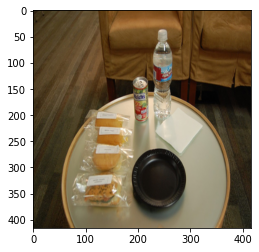

In [ ]:
plt.imshow(x_np.transpose([1,2,0]))

In [ ]:
len(anchors_torch)

8

In [ ]:
print(x_np.shape)
X_test = np.expand_dims(x_np,0)
print(X_test.shape)
myVGG.eval()
# handle the hack input
dummy_array = np.zeros((1, len(anchors_torch)//2, TRUE_BOX_BUFFER, 1,1,1))
y_pred = myVGG(torch.tensor(X_test).type(PRECISION).to(DEVICE)).to(torch.float)
print(y_pred.shape)

(3, 416, 416)
(1, 3, 416, 416)
torch.Size([1, 25, 4, 13, 13])


In [ ]:
y_np.shape

(6, 4, 13, 13)

In [ ]:
y_pred_np = y_pred.cpu().detach().numpy()[0]

In [ ]:
def np_exp_threshold(x, threshold=10):
  mask = (x<=threshold)
  tens = np.exp(np.array([threshold/2]))-threshold
  return np.exp(x*mask)*mask + (x+tens)**2*(~mask)

In [ ]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x, axis=-1, keepdims=True)


        mask_min = x < t
        x[mask_min] = t

        print(x[4,8,2])
        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout_0):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        netout = netout_0.transpose([2,3, 1, 0])
        GRID_H, GRID_W, BOX = netout.shape[:3]
      
        
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np_exp_threshold(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np_exp_threshold(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

In [ ]:
netout         = y_pred_np.copy()
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

[ -9.093262     0.          -6.1491585   -1.7143173   -9.378464
  -8.288296   -13.00988     -5.718746    -0.36594582  -4.9749947
  -0.33106613 -12.46907     -9.779007    -5.6821938   -7.2909966
  -2.133564    -5.269226    -1.618784   -10.501957    -7.27013   ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [ ]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    
                    box = utils.BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score(is_conf=False) > obj_threshold:
                        boxes.append(box)
    return(boxes)

In [ ]:
obj_threshold = 0.0000015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.3
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=1.5e-06
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 52 bounding boxes with top class probability > 1.5e-06

obj_threshold=0.3
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 3 bounding boxes with top class probability > 0.3


Plot with low object threshold
car        0.000 xmin= 207,ymin=   0,xmax= 212,ymax=  17
bottle     0.000 xmin= 276,ymin=   0,xmax= 278,ymax=  32
bottle     0.000 xmin= 305,ymin=   0,xmax= 306,ymax=  45
dining table 0.000 xmin= 332,ymin=   0,xmax= 338,ymax=  33
car        0.000 xmin= 398,ymin=   0,xmax= 404,ymax=  20
bottle     0.000 xmin= 146,ymin=  24,xmax= 147,ymax=  84
person     0.000 xmin= 402,ymin=  13,xmax= 404,ymax=  82
bottle     0.000 xmin= 144,ymin=  43,xmax= 144,ymax= 130
dining table 0.000 xmin= 187,ymin=  69,xmax= 211,ymax=  99
chair      0.000 xmin= 177,ymin=  15,xmax= 238,ymax= 171


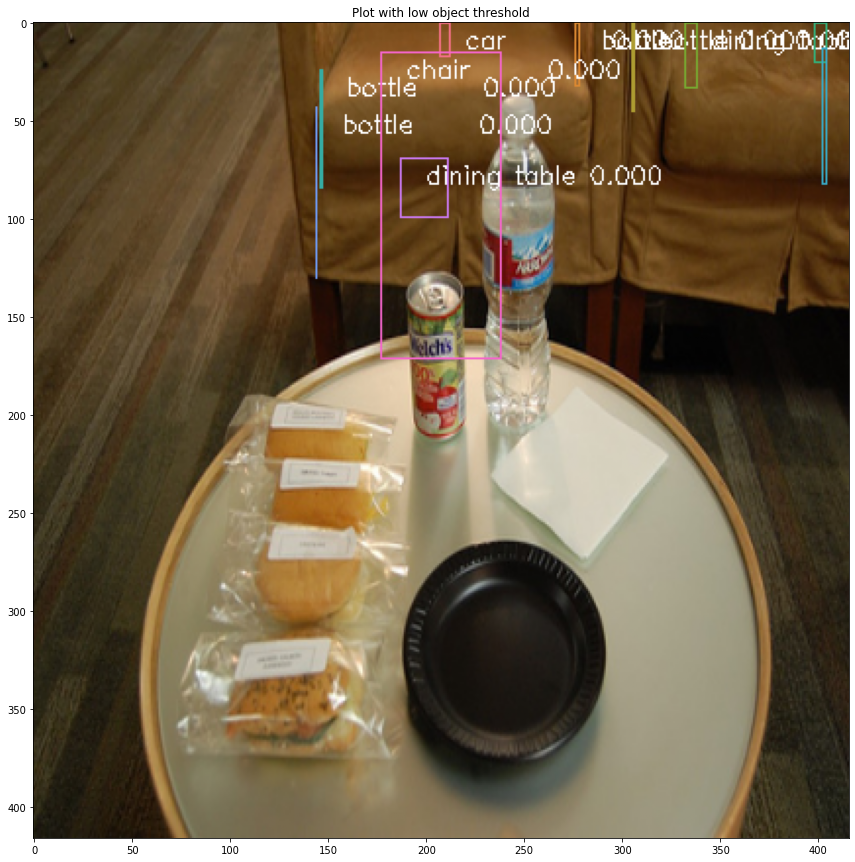

Plot with high object threshold
chair      0.911 xmin= 122,ymin=   4,xmax= 310,ymax= 180
chair      0.890 xmin= 301,ymin=   0,xmax= 412,ymax= 183
dining table 0.638 xmin=  69,ymin= 157,xmax= 372,ymax= 416


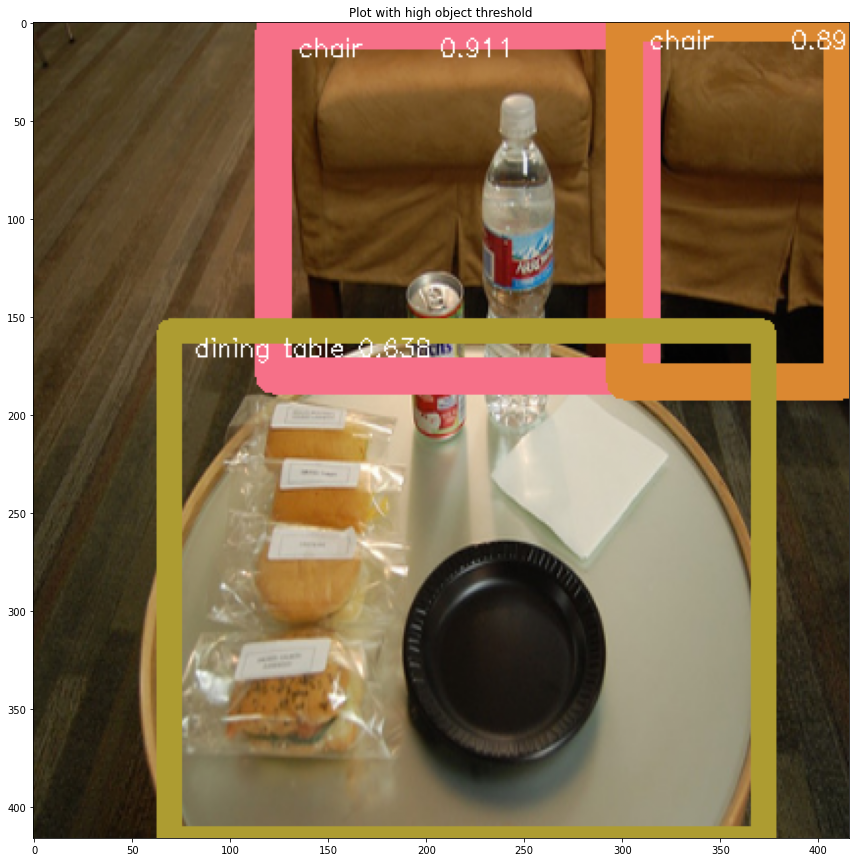

In [ ]:
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 10)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label_idx], box.get_score(is_conf=False))
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 1, 1),
                    thickness = 1)
        
    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0].transpose([1,2, 0]),boxes_tiny_threshold,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0].transpose([1,2,0]),boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()

In [ ]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = utils.BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c]*box.confidence for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = utils.calculate_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
    index_boxes = list(set(index_boxes))      
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score(is_conf=False) > obj_threshold ]                

    return newboxes

In [ ]:
iou_threshold = 0.6

final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

3 final number of boxes


chair      0.911 xmin= 122,ymin=   4,xmax= 310,ymax= 180
chair      0.890 xmin= 301,ymin=   0,xmax= 412,ymax= 183
dining table 0.638 xmin=  69,ymin= 157,xmax= 372,ymax= 416


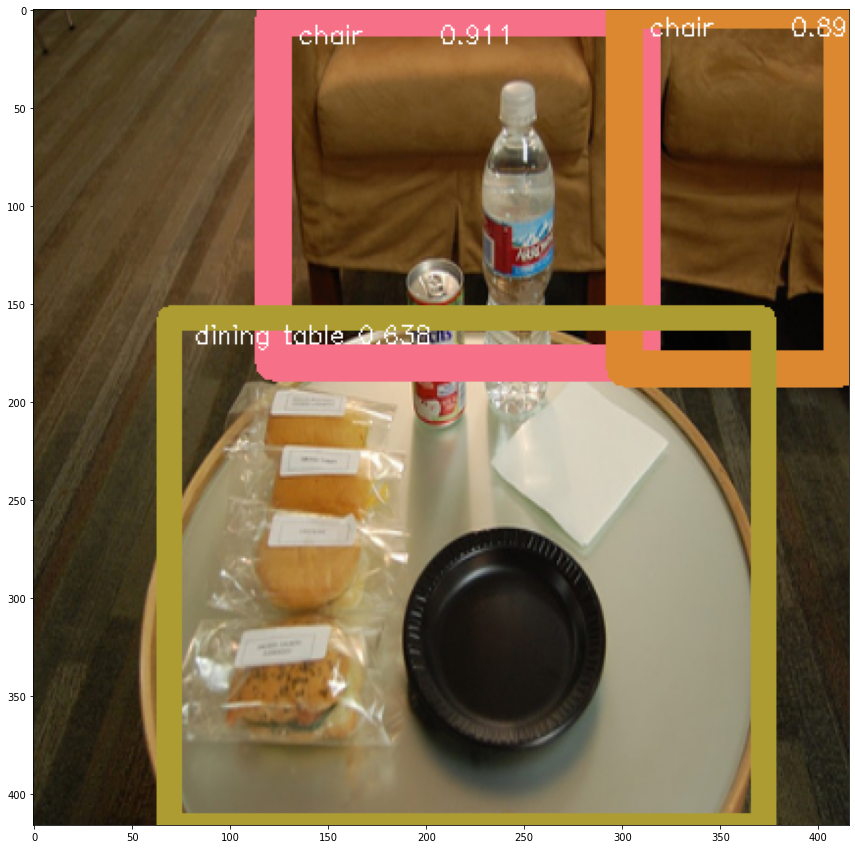

In [ ]:
ima = draw_boxes(X_test[0].transpose([1,2,0]),final_boxes,LABELS,verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()